In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import ast
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, filtfilt
from scipy.signal.windows import gaussian
from xgboost import XGBClassifier

# Dataset simulations FDTD

## Chargement du classifieur

In [2]:
# Recrée un XGBClassifier vide puis charge le modèle
clf_loaded = XGBClassifier()
clf_loaded.load_model("saved_models/xgb_model.json")

## Création du dataset

In [3]:
def extract_params_from_filename(filename):
    # Ex: simulation_w_429p955_DC_0p76_pitch_334p653_K_0p42_TE_24_Book_1_Feuil_1.dat
    # w, DC, pitch: après _w_, _DC_, _pitch_ (avec décimales utilisant 'p' au lieu de '.')
    match = re.search(r"w_([0-9p]+)_DC_([0-9p]+)_pitch_([0-9p]+)", filename)
    if not match:
        raise ValueError(f"Nom de fichier non reconnu: {filename}")
    w = float(match.group(1).replace('p', '.'))
    DC = float(match.group(2).replace('p', '.'))
    pitch = float(match.group(3).replace('p', '.'))
    return w, DC, pitch

def extract_k_and_spectrum(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    # Première ligne: on prend la 2e colonne (k)
    k = float(lines[0].strip().split()[1])
    # Les 5000 lignes suivantes: 2e colonne = spectre
    spectrum = [float(line.strip().split()[1]) for line in lines[1:5001]]
    return k, spectrum

In [10]:
# Dossier contenant les .dat
data_dir = "fdtd"
all_files = [f for f in os.listdir(data_dir) if f.endswith(".dat")]

data = []
for fname in all_files:
    w, DC, pitch = extract_params_from_filename(fname)
    k, spectrum = extract_k_and_spectrum(os.path.join(data_dir, fname))
    data.append({
        "w": w,
        "DC": DC,
        "pitch": pitch,
        "k": k,
        "E_5000": spectrum
    })

df = pd.DataFrame(data)
# Sauvegarde au format CSV (E_5000 comme string de liste)
df.to_csv("simu_dataset.csv", index=False)
print("Fichier CSV créé: simu_dataset.csv")

Fichier CSV créé: simu_dataset.csv


In [11]:
dataset = pd.read_csv('simu_dataset.csv')
print("Shape :", dataset.shape)
print("Colonnes :", dataset.columns.tolist())
print(dataset.head(20))
print(dataset.describe())

Shape : (562, 5)
Colonnes : ['w', 'DC', 'pitch', 'k', 'E_5000']
          w    DC    pitch          k  \
0   255.688  0.66  499.945  6242004.5   
1   259.583  0.68  496.993  6242631.5   
2   259.740  0.69  497.467  6240400.5   
3   261.535  0.65  501.012  6240469.0   
4   263.457  0.68  497.643  6242570.5   
5   265.699  0.69  497.276  6239052.0   
6   266.146  0.64  494.551  6241910.0   
7   266.779  0.65  496.105  6242578.5   
8   268.194  0.68  495.700  6239627.5   
9   288.595  0.78  503.993  6190741.5   
10  294.627  0.64  512.279  6809602.5   
11  297.244  0.61  510.719  6806996.5   
12  299.003  0.72  479.605  6963285.0   
13  309.807  0.51  516.255  6803894.5   
14  312.586  0.68  499.253  6806922.5   
15  316.015  0.66  497.983  6804532.5   
16  320.283  0.75  461.290  6592702.5   
17  325.540  0.72  497.792  6075355.5   
18  328.454  0.56  499.187  6728104.0   
19  335.808  0.70  497.851  6077488.5   

                                               E_5000  
0   [0.00012518839

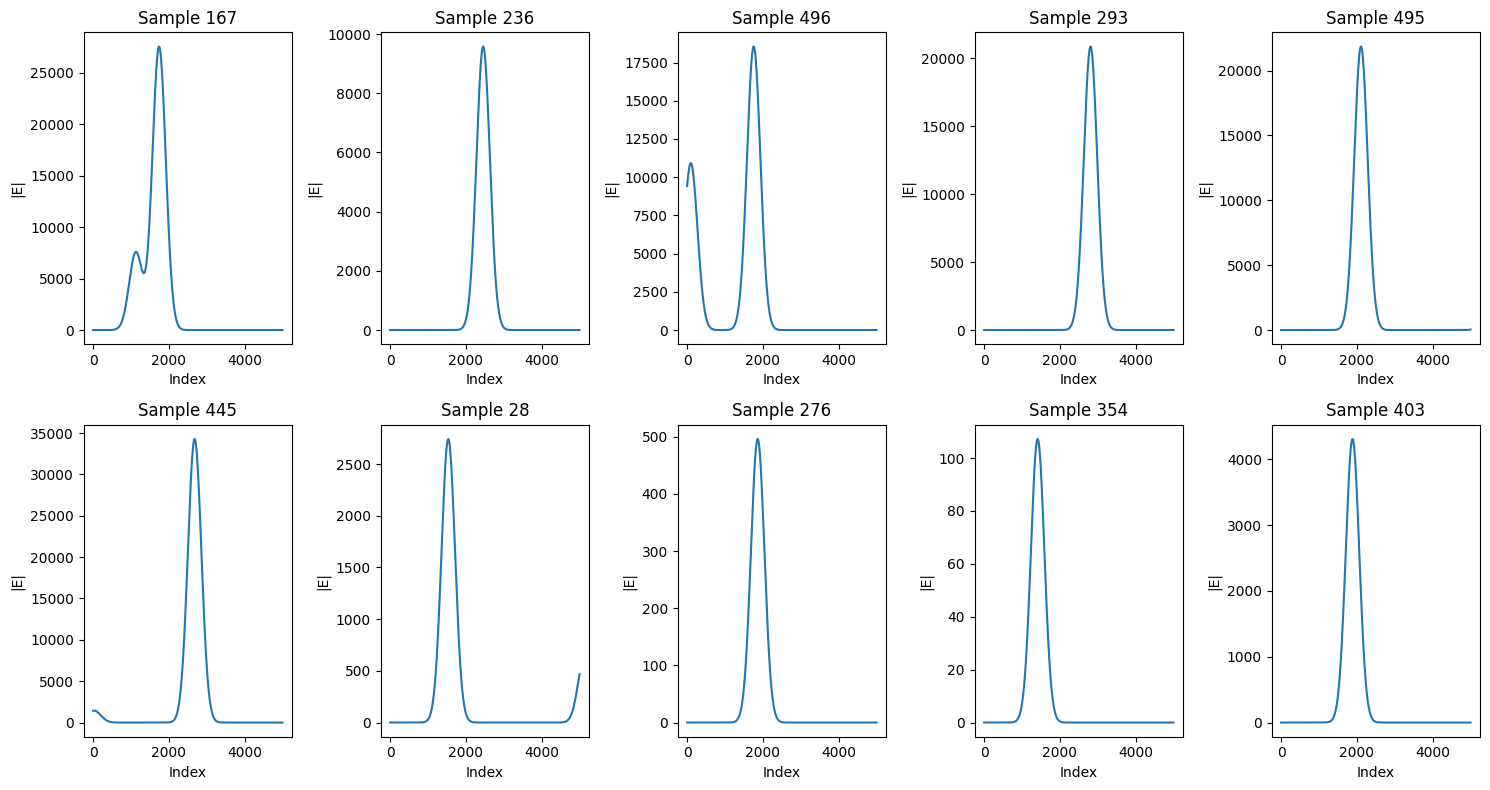

In [12]:
# Conversion de la colonne E_5000 de string vers liste de floats
dataset['E_5000'] = dataset['E_5000'].apply(ast.literal_eval)

# Tirer 10 indices aléatoires
indices = np.random.choice(dataset.shape[0], 10, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.plot(dataset['E_5000'].iloc[idx])
    plt.title(f"Sample {idx}")
    plt.xlabel("Index")
    plt.ylabel("|E|")
plt.tight_layout()
plt.show()

In [13]:
# Création de x_data (4 paramètres) et y_data (spectres)
x_data = dataset[['w', 'DC', 'pitch', 'k']].values.astype(np.float32)  # shape (N, 4)
y_data = np.stack(dataset['E_5000'].values).astype(np.float32)         # shape (N, 5000)

print("x_data shape:", x_data.shape)
print("y_data shape:", y_data.shape)

x_data shape: (562, 4)
y_data shape: (562, 5000)


In [15]:
df = pd.DataFrame(x_data, columns=['w', 'DC', 'pitch', 'k'])
df.to_csv("mon_fichier.csv", index=False)

In [9]:
# Sauvegarde dans fdtd/ au format npy
os.makedirs("fdtd", exist_ok=True)
np.save("fdtd/x_data.npy", x_data)
np.save("fdtd/y_data.npy", y_data)

print("x_data et y_data sauvegardés dans fdtd/")

x_data et y_data sauvegardés dans fdtd/


## Filtrage spectres

## Prédiction des spectres 0 ou 1+

In [8]:
y_data_norm = (y_data - y_data.min(axis=1, keepdims=True)) / (y_data.max(axis=1, keepdims=True) - y_data.min(axis=1, keepdims=True) + 1e-12)
y_data_clf = y_data_norm[:, ::10]  # Réduction à 500 points

print("y_data_clf shape:", y_data_clf.shape)

y_data_clf shape: (10831, 500)


In [9]:
label_pred = clf_loaded.predict(y_data_clf)

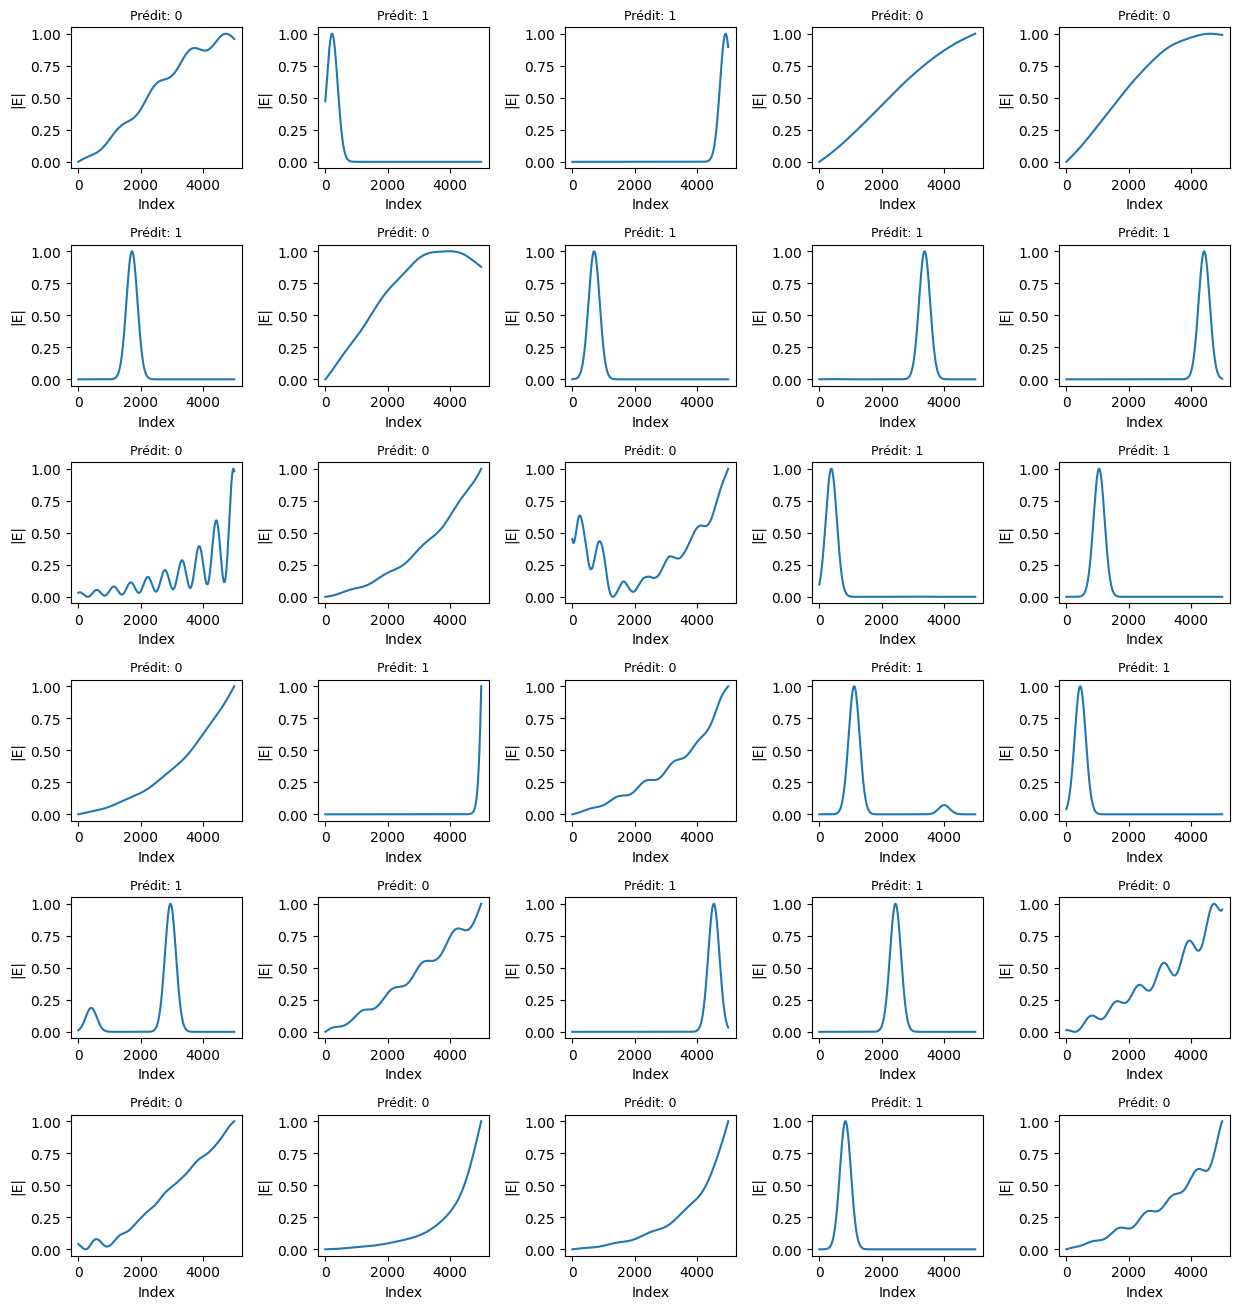

In [10]:
# Tirer 30 indices aléatoires
n_examples = 30
indices = np.random.choice(y_data.shape[0], n_examples, replace=False)

n_cols = 5
n_rows = 6

plt.figure(figsize=(2.5 * n_cols, 2.2 * n_rows))
for i, idx in enumerate(indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(y_data_norm[idx])
    plt.title(f"Prédit: {label_pred[idx]}", fontsize=9)
    plt.xlabel("Index")
    plt.ylabel("|E|")
plt.tight_layout()
plt.show()

In [11]:
# Séléction des données avec 1+ pic
mask = (label_pred == 1)
x_data_selected = x_data[mask]
y_data_selected = y_data[mask]
y_data_selected = (y_data_selected - y_data_selected.min(axis=1, keepdims=True)) / (y_data_selected.max(axis=1, keepdims=True) - y_data_selected.min(axis=1, keepdims=True) + 1e-12)
print("x_data_selected shape:", x_data_selected.shape)
print("y_data_selected shape:", y_data_selected.shape)
# ...existing code...

x_data_selected shape: (5142, 4)
y_data_selected shape: (5142, 5000)


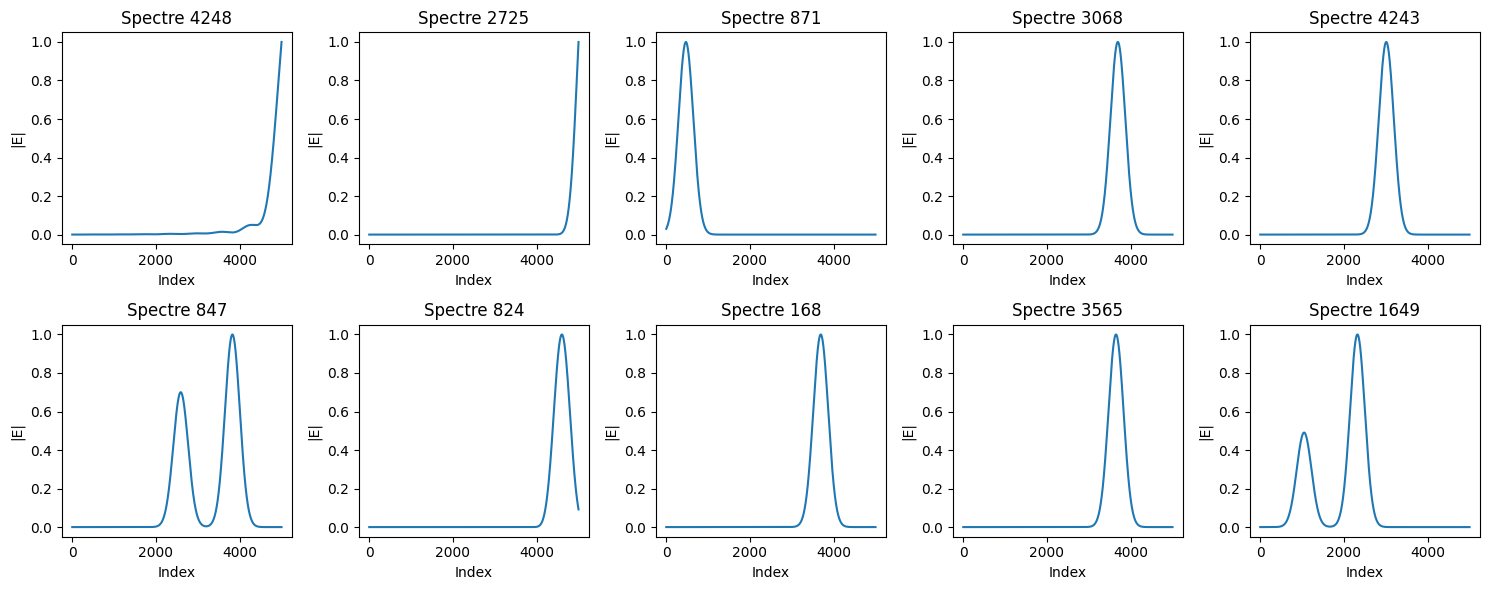

In [12]:
# Afficher aléatoirement 10 spectres de y_data_selected
n_examples = 10
indices = np.random.choice(y_data_selected.shape[0], n_examples, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.plot(y_data_selected[idx])
    plt.title(f"Spectre {idx}")
    plt.xlabel("Index")
    plt.ylabel("|E|")
plt.tight_layout()
plt.show()

## Séparation entre spectres 1 et 2 pics

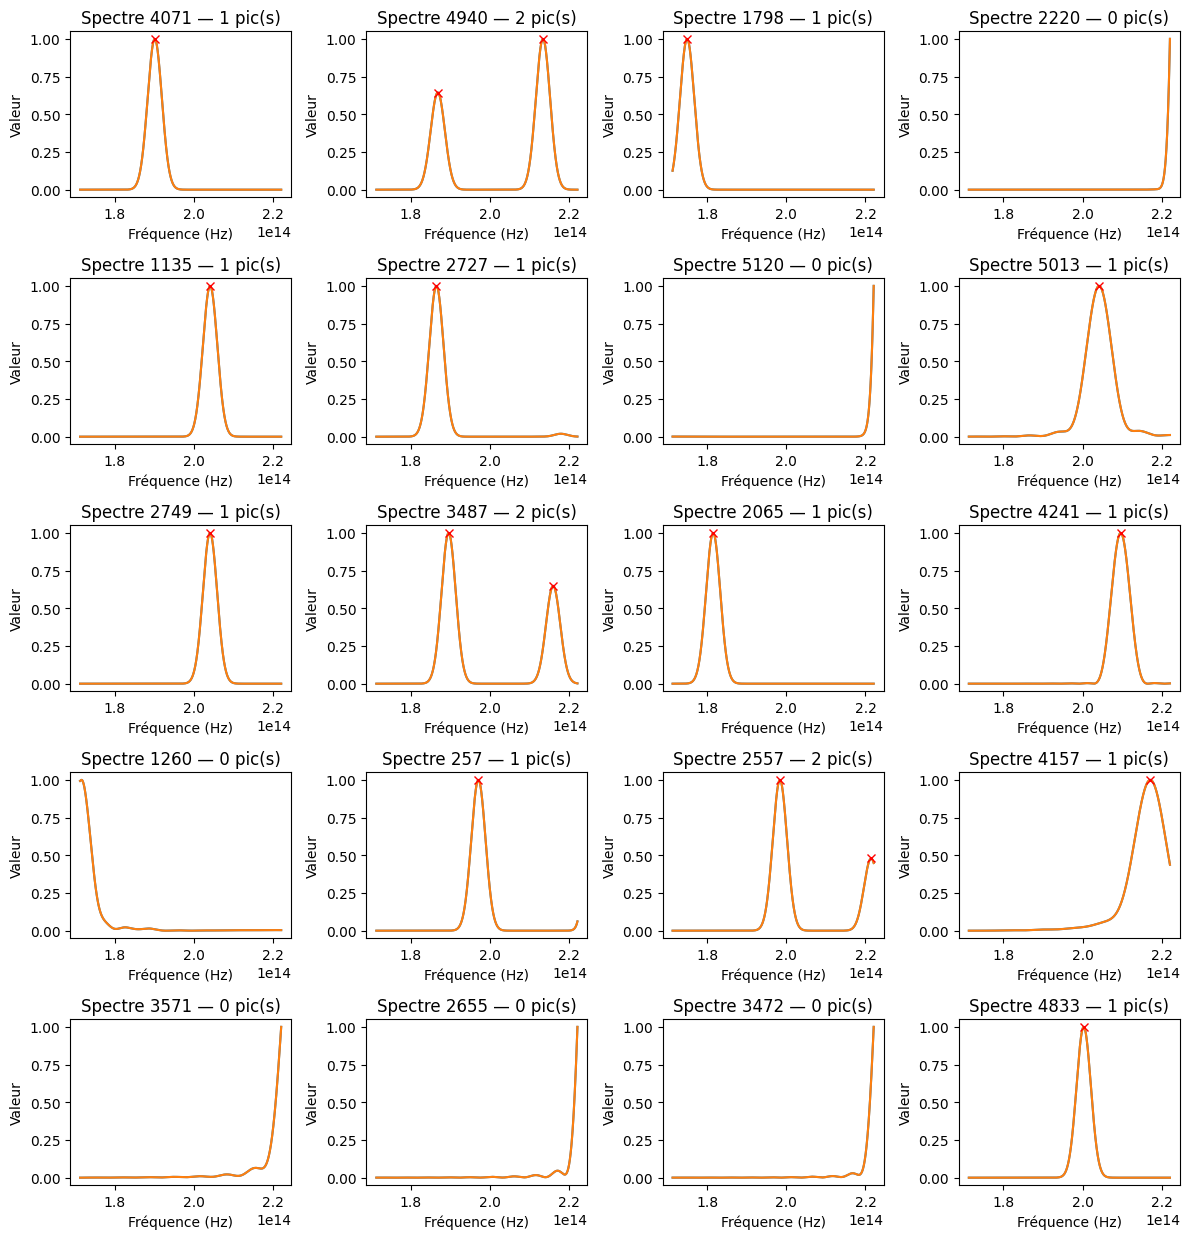

In [13]:
# Paramètres du filtre et de détection
window = gaussian(M=21, std=5)
window /= window.sum()
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

height=0.1,
prominence=0.01,
distance=5

# Sélectionne 20 indices aléatoires pour visualisation
n_plot = 20
indices = np.random.choice(len(y_data_selected), n_plot, replace=False)

plt.figure(figsize=(12, 2.5 * (n_plot // 4)))

for idx, i in enumerate(indices):
    y = y_data_selected[i]
    y_smooth = filtfilt(window, [1], y)
    peaks, props = find_peaks(
        y_smooth,
        height=height,
        prominence=prominence,
        distance=distance
    )

    # Affichage
    plt.subplot(n_plot // 4, 4, idx + 1)
    plt.plot(frequencies, y, label="original")
    plt.plot(frequencies, y_smooth, label="lissé")
    plt.plot(frequencies[peaks], y_smooth[peaks], "x", label="pics détectés", color='red')
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Valeur")
    plt.title(f"Spectre {i} — {len(peaks)} pic(s)")
    plt.tight_layout()

In [14]:
peak_counts = []
filtered_gen_y_1 = []
filtered_gen_x_1 = []
filtered_gen_y_2 = []
filtered_gen_x_2 = []

for i in range(len(y_data_selected)):
    y = y_data_selected[i]
    y_smooth = filtfilt(window, [1], y)

    peaks, _ = find_peaks(
        y_smooth,
        height=height,
        prominence=prominence,
        distance=distance
    )

    peak_counts.append(len(peaks))

    if len(peaks) == 1:
        filtered_gen_y_1.append(y[np.newaxis, :])
        filtered_gen_x_1.append(x_data_selected[i][np.newaxis, :])
    elif len(peaks) == 2:
        filtered_gen_y_2.append(y[np.newaxis, :])
        filtered_gen_x_2.append(x_data_selected[i][np.newaxis, :])

# Concaténer les spectres filtrés pour 1 pic
if filtered_gen_y_1:
    filtered_gen_y_1 = np.concatenate(filtered_gen_y_1, axis=0)
    filtered_gen_x_1 = np.concatenate(filtered_gen_x_1, axis=0)
else:
    filtered_gen_y_1 = np.empty((0, y_data_selected.shape[1]))
    filtered_gen_x_1 = np.empty((0, x_data_selected.shape[1]))

# Concaténer les spectres filtrés pour 2 pics
if filtered_gen_y_2:
    filtered_gen_y_2 = np.concatenate(filtered_gen_y_2, axis=0)
    filtered_gen_x_2 = np.concatenate(filtered_gen_x_2, axis=0)
else:
    filtered_gen_y_2 = np.empty((0, y_data_selected.shape[1]))
    filtered_gen_x_2 = np.empty((0, x_data_selected.shape[1]))

# Résumé
print("filtered_gen_y_1 shape:", filtered_gen_y_1.shape)
print("filtered_gen_x_1 shape:", filtered_gen_x_1.shape)
print("filtered_gen_y_2 shape:", filtered_gen_y_2.shape)
print("filtered_gen_x_2 shape:", filtered_gen_x_2.shape)
print(f"{len(peak_counts)} spectres traités.")
print(f"{filtered_gen_y_1.shape[0]} spectres avec exactement 1 pic.")
print(f"{filtered_gen_y_2.shape[0]} spectres avec exactement 2 pics.")

filtered_gen_y_1 shape: (3985, 5000)
filtered_gen_x_1 shape: (3985, 4)
filtered_gen_y_2 shape: (584, 5000)
filtered_gen_x_2 shape: (584, 4)
5142 spectres traités.
3985 spectres avec exactement 1 pic.
584 spectres avec exactement 2 pics.


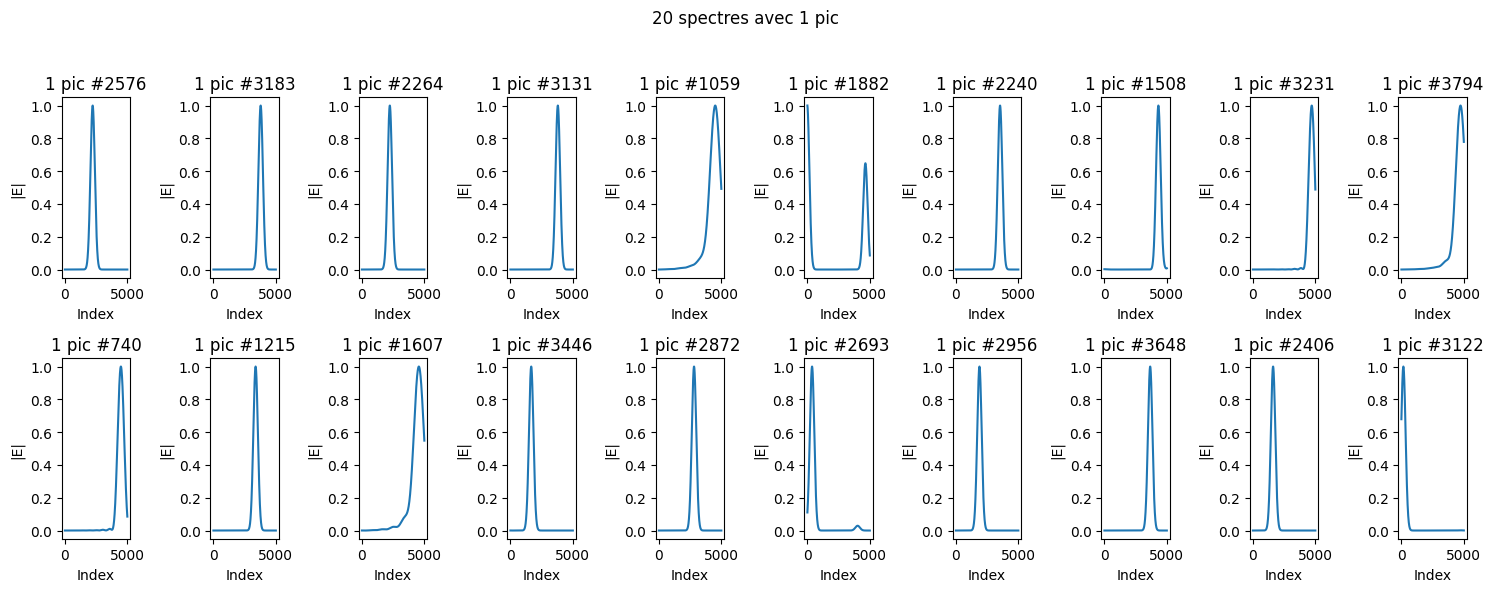

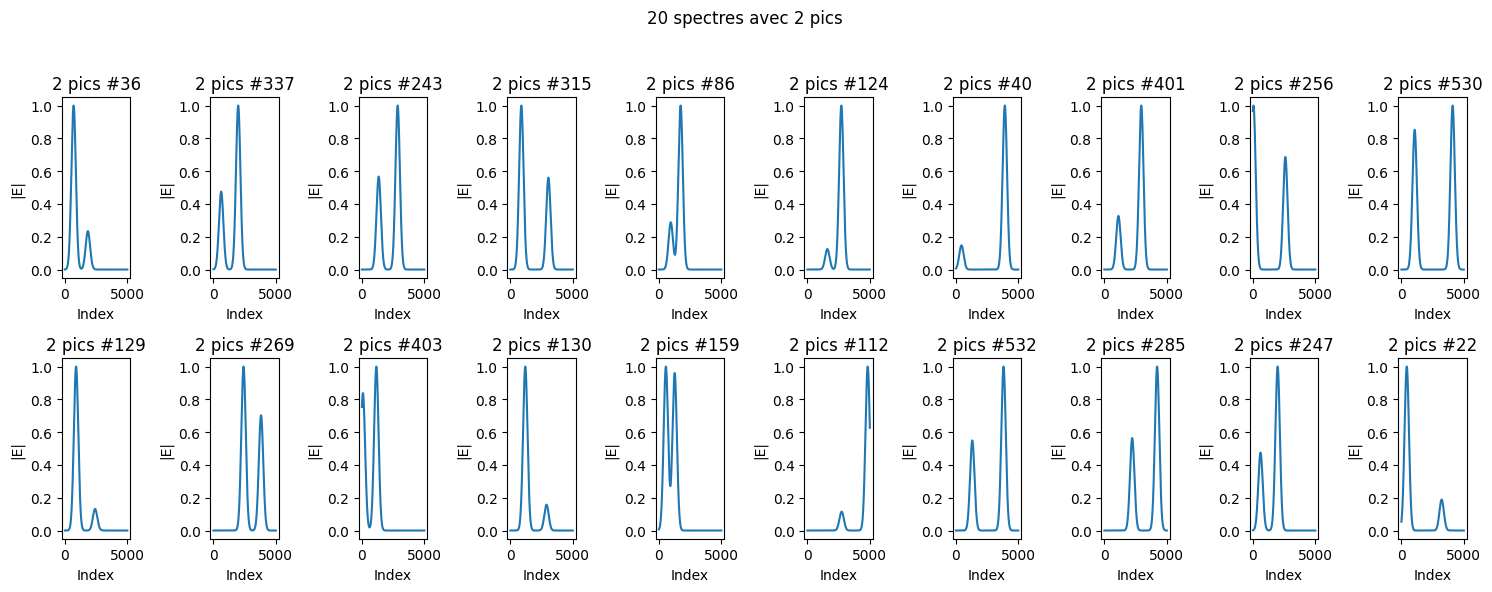

In [15]:
# Pour 20 spectres à 1 pic
n_1 = min(20, filtered_gen_y_1.shape[0])
indices_1 = np.random.choice(filtered_gen_y_1.shape[0], n_1, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices_1):
    plt.subplot(2, 10, i + 1)
    plt.plot(filtered_gen_y_1[idx])
    plt.title(f"1 pic #{idx}")
    plt.xlabel("Index")
    plt.ylabel("|E|")
plt.suptitle("20 spectres avec 1 pic")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Pour 20 spectres à 2 pics
n_2 = min(20, filtered_gen_y_2.shape[0])
indices_2 = np.random.choice(filtered_gen_y_2.shape[0], n_2, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices_2):
    plt.subplot(2, 10, i + 1)
    plt.plot(filtered_gen_y_2[idx])
    plt.title(f"2 pics #{idx}")
    plt.xlabel("Index")
    plt.ylabel("|E|")
plt.suptitle("20 spectres avec 2 pics")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [57]:
# Crée le dossier data/ s'il n'existe pas
os.makedirs("data", exist_ok=True)

# Sauvegarde des arrays au format .npy
np.save("data/x_data1.npy", filtered_gen_x_1)
np.save("data/y_data1.npy", filtered_gen_y_1)
np.save("data/x_data2.npy", filtered_gen_x_2)
np.save("data/y_data2.npy", filtered_gen_y_2)

print("Fichiers sauvegardés dans le dossier data/")

Fichiers sauvegardés dans le dossier data/


## Concaténation des données

In [1]:
# Chargement des fichiers .npy
x_dataset1 = filtered_gen_x_1
y_dataset1 = filtered_gen_y_1
x_dataset2 = filtered_gen_x_2
y_dataset2 = filtered_gen_y_2

x_data1 = np.load("data_augmented/x_data1_big.npy")
y_data1 = np.load("data_augmented/y_data1_big.npy")
x_data2 = np.load("data_augmented/x_data2_big.npy")
y_data2 = np.load("data_augmented/y_data2_big.npy")

# Affichage des dimensions
print("x_dataset1 shape:", x_dataset1.shape)
print("y_dataset1 shape:", y_dataset1.shape)
print("x_dataset2 shape:", x_dataset2.shape)
print("y_dataset2 shape:", y_dataset2.shape)
print("x_data1 shape:", x_data1.shape)
print("y_data1 shape:", y_data1.shape)
print("x_data2 shape:", x_data2.shape)
print("y_data2 shape:", y_data2.shape)

# Concaténation pour former les datasets "big"
x_data1_bigger = np.concatenate([x_dataset1, x_data1], axis=0)
y_data1_bigger = np.concatenate([y_dataset1, y_data1], axis=0)
x_data2_bigger = np.concatenate([x_dataset2, x_data2], axis=0)
y_data2_bigger = np.concatenate([y_dataset2, y_data2], axis=0)

print("x_data1_big shape:", x_data1_bigger.shape)
print("y_data1_big shape:", y_data1_bigger.shape)
print("x_data2_big shape:", x_data2_bigger.shape)
print("y_data2_big shape:", y_data2_bigger.shape)

NameError: name 'filtered_gen_x_1' is not defined

In [17]:
x = x_data1_bigger # np.array de shape (N, 4)
if isinstance(x, np.ndarray):
    # On arrondit pour éviter les problèmes de flottants
    arr = np.round(x, decimals=1)
    # On utilise np.unique sur les lignes
    _, idx_unique = np.unique(arr, axis=0, return_index=True)
    n_total = arr.shape[0]
    n_unique = len(idx_unique)
    if n_total == n_unique:
        print("Aucun doublon trouvé.")
    else:
        print(f"{n_total - n_unique} doublon(s) trouvé(s).")
else:
    print("x_1pic_filt_2 n'est pas un numpy array.")

1687 doublon(s) trouvé(s).


In [18]:
# Sauvegarde des arrays au format .npy dans data_augmented/
np.save("data_augmented/x_data1_bigger.npy", x_data1_bigger)
np.save("data_augmented/y_data1_bigger.npy", y_data1_bigger)
np.save("data_augmented/x_data2_bigger.npy", x_data2_bigger)
np.save("data_augmented/y_data2_bigger.npy", y_data2_bigger)

print("Fichiers sauvegardés dans le dossier data_augmented/")

Fichiers sauvegardés dans le dossier data_augmented/


### Labels

In [19]:
# Constantes
c = 299_792_458  # vitesse de la lumière en m/s
frequencies = np.linspace(171309976000000, 222068487407407, y_data1_bigger.shape[1])  # (5000,)

# Récupérer k pour chaque x (supposé être la 4ème colonne)
k = x_data1_bigger[:, 3]  # (n,)

# Trouver l'indice du max pour chaque spectre y
idx_max = np.argmax(y_data1_bigger, axis=1)  # (n,)

# Fréquence du max pour chaque spectre
f_max = frequencies[idx_max]  # (n,)

# Calcul de n_eff pour chaque échantillon
n_eff = (c * k) / (2 * np.pi * f_max)  # (n,)

# Création du label_data (n, 2)
label_data1_bigger = np.stack([f_max, n_eff], axis=1)  # (n, 2)

print("label_data shape:", label_data1_bigger.shape)
print("Premières lignes :\n", label_data1_bigger[:5])

label_data shape: (10131, 2)
Premières lignes :
 [[1.94074645e+14 1.46937503e+00]
 [2.09884008e+14 1.51743910e+00]
 [2.20311892e+14 1.56754652e+00]
 [2.16778392e+14 1.10532720e+00]
 [2.16087939e+14 1.57431274e+00]]


In [20]:
# Sauvegarde les fichiers au format .npy
np.save('data_augmented/label_data1_bigger.npy', label_data1_bigger)

In [22]:
label_data1_bigger = np.load('data_augmented/label_data1_bigger.npy')
print(label_data1_bigger.shape)
print(label_data1_bigger[:5])

(10131, 2)
[[1.94074645e+14 1.46937503e+00]
 [2.09884008e+14 1.51743910e+00]
 [2.20311892e+14 1.56754652e+00]
 [2.16778392e+14 1.10532720e+00]
 [2.16087939e+14 1.57431274e+00]]


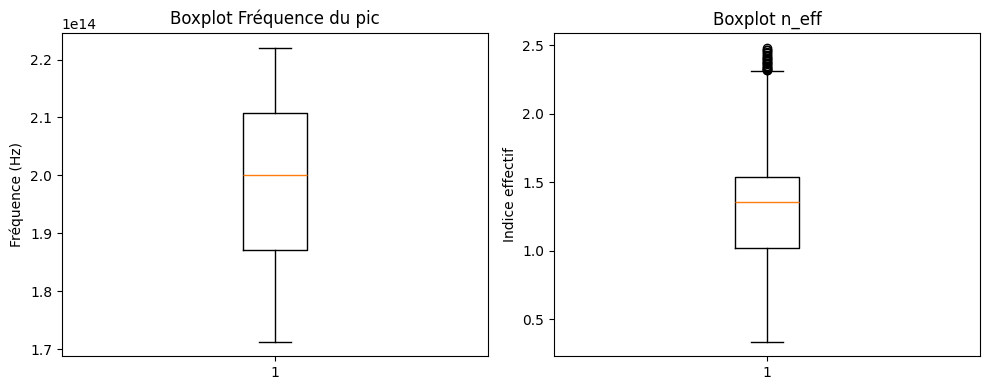

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(label_data1_bigger[:, 0])
plt.title("Boxplot Fréquence du pic")
plt.ylabel("Fréquence (Hz)")

plt.subplot(1, 2, 2)
plt.boxplot(label_data1_bigger[:, 1])
plt.title("Boxplot n_eff")
plt.ylabel("Indice effectif")

plt.tight_layout()
plt.show()

# FNN Training 1 ou 2 pics

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import optuna
import seaborn as sns
from CVAE.cvae import CVAEIntegrated
from CVAE.feedforwardNN import FeedforwardNN
from torch.utils.data import DataLoader
from optuna.pruners import HyperbandPruner
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from utils.dataload import prepare_data_loaders, set_seed
print(torch.cuda.is_available())        # True
print(torch.cuda.get_device_name(0))    # Nom du GPU
set_seed(42) 

True
NVIDIA T400 4GB


In [45]:
# Préparation des données
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Chargement des arrays au format .npy
x_data_big = np.load("data_augmented/x_data2_bigger.npy")
y_data_big = np.load("data_augmented/y_data2_bigger.npy")

print("x_data_big shape:", x_data_big.shape)
print("y_data_big shape:", y_data_big.shape)

# Split train/test
X_train, X_test, Y_train, Y_test = train_test_split(
    x_data_big, y_data_big, test_size=0.2, random_state=42
)

# Normalisation des entrées sur le train uniquement, puis applique au test
scaler_x = StandardScaler()
X_train_norm = scaler_x.fit_transform(X_train)
X_test_norm = scaler_x.transform(X_test)

# Conversion en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Création des DataLoader pour le FNN
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

print("Train DataLoader prêt pour le FNN.")
print("Test DataLoader prêt pour le FNN.")

Using device: cuda
x_data_big shape: (1085, 4)
y_data_big shape: (1085, 5000)
Train DataLoader prêt pour le FNN.
Test DataLoader prêt pour le FNN.


In [47]:
import optuna
import torch
from optuna.pruners import HyperbandPruner
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def objective(trial):
    # Hyperparamètres à optimiser
    n_layers = trial.suggest_int("n_layers", 2, 8)
    hidden_dim_list = []
    for i in range(n_layers):
        hidden_dim = trial.suggest_int(f"hidden_dim{i+1}", 512, 2700, step=256)
        hidden_dim_list.append(hidden_dim)

    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    #batch_size = trial.suggest_categorical("batch_size", [128,256])
    print("Hyperparamètres suggérés :", hidden_dim_list, dropout, lr, batch_size)

    # Préparation des DataLoader
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=batch_size, shuffle=False)

    # Modèle
    model = FeedforwardNN(4, 5000, hidden_dim_list, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    num_epochs = 200
    for epoch in range(num_epochs):
        # Entraînement
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)

        # Affichage des losses à chaque epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        # Report à Optuna pour le pruner
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            print("Trial pruned at epoch", epoch+1)
            raise optuna.TrialPruned()
    return avg_val_loss

# Lancement de l'optimisation Optuna avec pruner
# Pruner très agressif
pruner = HyperbandPruner(
    min_resource=20,           # nombre d'epochs minimum avant de pruner
    max_resource=200,         # nombre d'epochs max (doit correspondre à num_epochs)
    reduction_factor=4        # plus élevé = plus agressif
)
study = optuna.create_study(direction="minimize", pruner=pruner)
#Hyperparamètres suggérés : [1984, 928, 1824, 1056, 960, 1696] 5.8659567934431656e-05 0.0001030253410175308 128 (FNN1)

#FNN1
# study.enqueue_trial({
#     "n_layers": 6,
#     "hidden_dim1": 1984,
#     "hidden_dim2": 928,
#     "hidden_dim3": 1824,
#     "hidden_dim4": 1056,
#     "hidden_dim5": 960,
#     "hidden_dim6": 1696,
#     "dropout": 5.8659567934431656e-05,
#     "lr": 0.0001030253410175308,
#     "batch_size": 128
# })

# FNN2 :
study.enqueue_trial({
    "n_layers": 5,
    "hidden_dim1": 2304,
    "hidden_dim2": 1280,
    "hidden_dim3": 2304,
    "hidden_dim4": 512,
    "hidden_dim5": 2304,
    "dropout": 0.0001146291185467514,
    "lr": 0.00018712825536139918,
    "batch_size": 64
})

study.optimize(objective, n_trials=1)

print("Meilleurs hyperparamètres :", study.best_params)
print("Meilleure loss de validation :", study.best_value)

[I 2025-07-22 16:46:08,426] A new study created in memory with name: no-name-084b4d80-7839-41e9-a9cc-0b79b751d52a


Hyperparamètres suggérés : [2304, 1280, 2304, 512, 2304] 0.0001146291185467514 0.00018712825536139918 128
Epoch 1/200 - Train Loss: 0.0731 - Val Loss: 0.0650
Epoch 2/200 - Train Loss: 0.0639 - Val Loss: 0.0624
Epoch 3/200 - Train Loss: 0.0606 - Val Loss: 0.0594
Epoch 4/200 - Train Loss: 0.0573 - Val Loss: 0.0575
Epoch 5/200 - Train Loss: 0.0557 - Val Loss: 0.0559
Epoch 6/200 - Train Loss: 0.0535 - Val Loss: 0.0535
Epoch 7/200 - Train Loss: 0.0507 - Val Loss: 0.0498
Epoch 8/200 - Train Loss: 0.0471 - Val Loss: 0.0462
Epoch 9/200 - Train Loss: 0.0435 - Val Loss: 0.0432
Epoch 10/200 - Train Loss: 0.0401 - Val Loss: 0.0393
Epoch 11/200 - Train Loss: 0.0367 - Val Loss: 0.0363
Epoch 12/200 - Train Loss: 0.0339 - Val Loss: 0.0342
Epoch 13/200 - Train Loss: 0.0317 - Val Loss: 0.0330
Epoch 14/200 - Train Loss: 0.0292 - Val Loss: 0.0309
Epoch 15/200 - Train Loss: 0.0275 - Val Loss: 0.0280
Epoch 16/200 - Train Loss: 0.0253 - Val Loss: 0.0264
Epoch 17/200 - Train Loss: 0.0236 - Val Loss: 0.0255
Ep

[I 2025-07-22 16:47:08,421] Trial 0 finished with value: 0.003810600144788623 and parameters: {'n_layers': 5, 'hidden_dim1': 2304, 'hidden_dim2': 1280, 'hidden_dim3': 2304, 'hidden_dim4': 512, 'hidden_dim5': 2304, 'dropout': 0.0001146291185467514, 'lr': 0.00018712825536139918}. Best is trial 0 with value: 0.003810600144788623.


Epoch 200/200 - Train Loss: 0.0004 - Val Loss: 0.0038
Meilleurs hyperparamètres : {'n_layers': 5, 'hidden_dim1': 2304, 'hidden_dim2': 1280, 'hidden_dim3': 2304, 'hidden_dim4': 512, 'hidden_dim5': 2304, 'dropout': 0.0001146291185467514, 'lr': 0.00018712825536139918}
Meilleure loss de validation : 0.003810600144788623


In [48]:
# Stocke les meilleurs hyperparamètres pour réutilisation
best_params = study.best_params
hidden_dim_list = [best_params[f"hidden_dim{i+1}"] for i in range(best_params["n_layers"])]
dropout = best_params["dropout"]
lr = best_params["lr"]
#batch_size = best_params["batch_size"]

print("hidden_dim_list =", hidden_dim_list)
print("dropout =", dropout)
print("lr =", lr)
print("batch_size =", batch_size)

hidden_dim_list = [2304, 1280, 2304, 512, 2304]
dropout = 0.0001146291185467514
lr = 0.00018712825536139918
batch_size = 128


Epoch 1/500 - Train Loss: 0.0729 - Val Loss: 0.0647
Epoch 2/500 - Train Loss: 0.0638 - Val Loss: 0.0622
Epoch 3/500 - Train Loss: 0.0602 - Val Loss: 0.0591
Epoch 4/500 - Train Loss: 0.0573 - Val Loss: 0.0576
Epoch 5/500 - Train Loss: 0.0555 - Val Loss: 0.0558
Epoch 6/500 - Train Loss: 0.0532 - Val Loss: 0.0532
Epoch 7/500 - Train Loss: 0.0506 - Val Loss: 0.0501
Epoch 8/500 - Train Loss: 0.0474 - Val Loss: 0.0467
Epoch 9/500 - Train Loss: 0.0442 - Val Loss: 0.0436
Epoch 10/500 - Train Loss: 0.0408 - Val Loss: 0.0400
Epoch 11/500 - Train Loss: 0.0376 - Val Loss: 0.0375
Epoch 12/500 - Train Loss: 0.0348 - Val Loss: 0.0351
Epoch 13/500 - Train Loss: 0.0323 - Val Loss: 0.0320
Epoch 14/500 - Train Loss: 0.0294 - Val Loss: 0.0298
Epoch 15/500 - Train Loss: 0.0274 - Val Loss: 0.0286
Epoch 16/500 - Train Loss: 0.0257 - Val Loss: 0.0264
Epoch 17/500 - Train Loss: 0.0239 - Val Loss: 0.0258
Epoch 18/500 - Train Loss: 0.0221 - Val Loss: 0.0239
Epoch 19/500 - Train Loss: 0.0202 - Val Loss: 0.0223
Ep

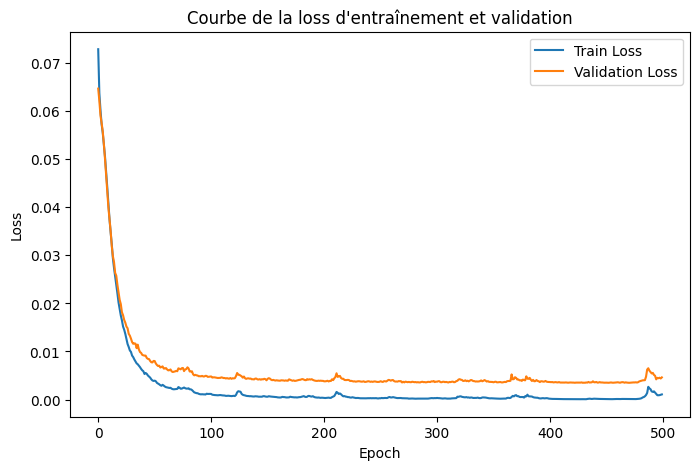

In [49]:
# Modèle
model = FeedforwardNN(4, 5000, hidden_dim_list, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 500  # Nombre d'époques pour l'entraînement
# Entraînement
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # <-- passage sur CUDA
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)  # <-- passage sur CUDA
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

# Affichage des courbes de loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la loss d'entraînement et validation")
plt.legend()
plt.show()

In [50]:
# Passe le modèle en mode évaluation
model.eval()

# Récupère un batch du train_loader
xb, yb = next(iter(test_loader))
xb, yb = xb.to(device), yb.to(device)

# Prédiction
with torch.no_grad():
    y_pred = model(xb).cpu().numpy()
    y_true = yb.cpu().numpy()

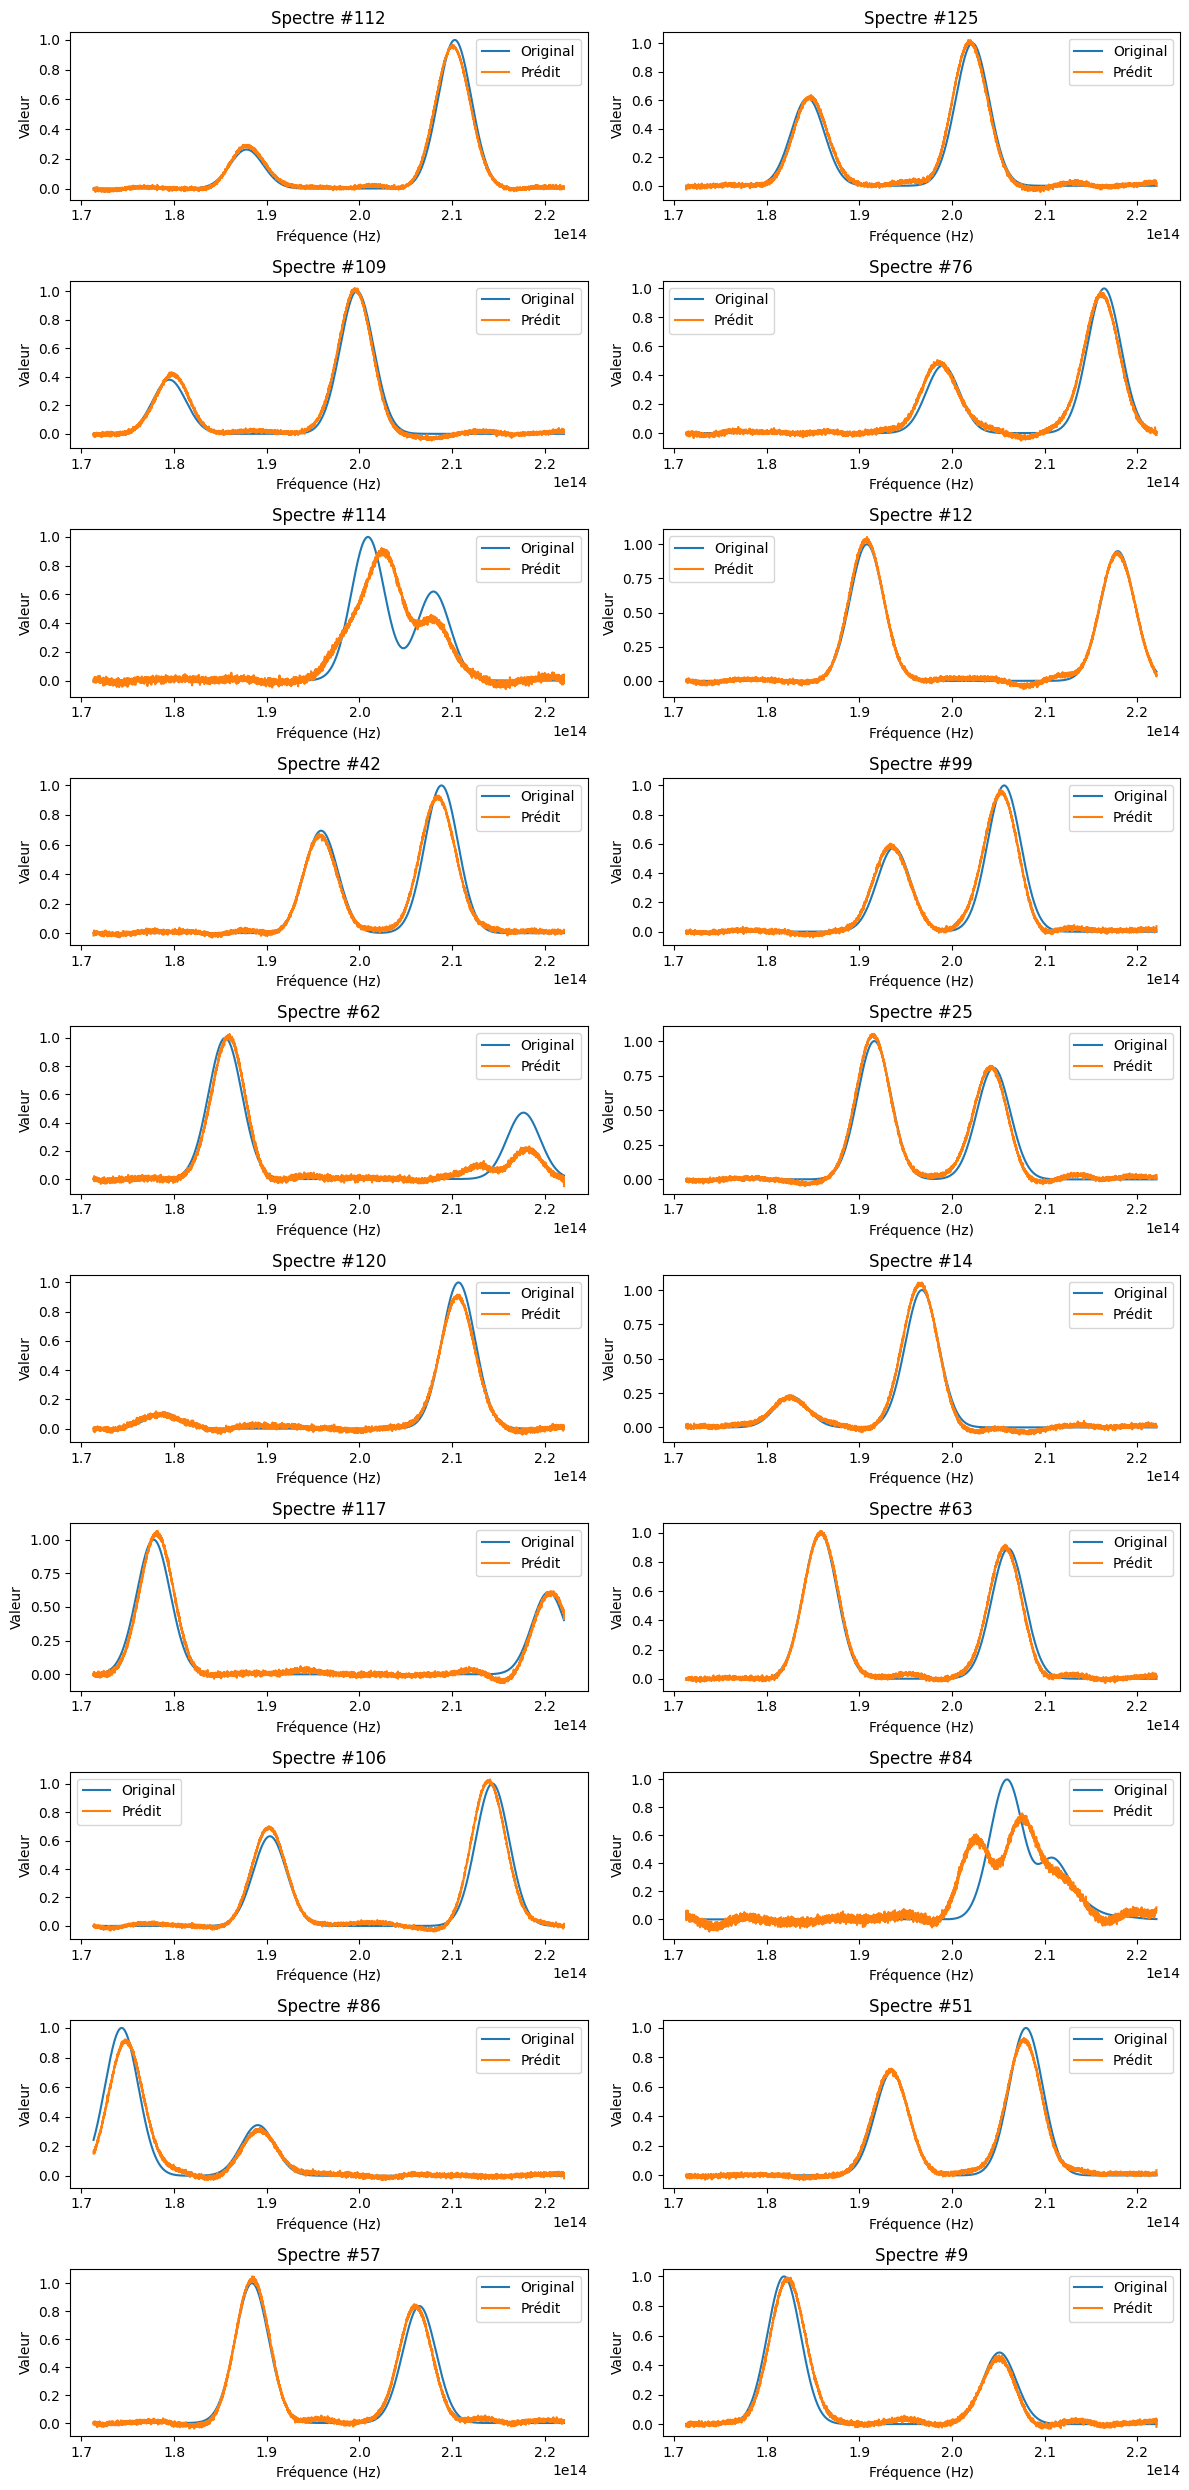

In [53]:
# Affiche la superposition pour 20 spectres du batch, deux colonnes côte à côte
n_plot =20
indices = np.random.choice(y_true.shape[0], n_plot, replace=False)
frequencies = np.linspace(171309976000000, 222068487407407, 5000)

plt.figure(figsize=(12, 2.5 * (n_plot // 2)))
for i, idx in enumerate(indices):
    plt.subplot(n_plot // 2, 2, i + 1)
    plt.plot(frequencies, y_true[idx], label="Original")
    plt.plot(frequencies, y_pred[idx], label="Prédit")
    plt.title(f"Spectre #{idx}")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Valeur")
    plt.legend()
plt.tight_layout()
plt.show()

In [21]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "input_dim": 4,
    "output_dim": 5000,
    "hidden_dim_list": hidden_dim_list,
    "dropout": dropout,
    "lr": lr,
    # Ajoute le scaler si tu veux le sauvegarder aussi
    "scaler_x": scaler_x,
}
import torch
torch.save(checkpoint, "saved_models/ffn_2pic.pth")
print("Modèle FNN sauvegardé dans saved_models/ffn_big_trained.pth")

Modèle FNN sauvegardé dans saved_models/ffn_big_trained.pth
